#Everything that follows, was tested and run on Google Colab. The excel with the necessary data was uploaded before running the main cell.

The following downloads and imports are needed for the whole project.

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from keras_tuner.tuners import Hyperband
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

The following function is used to clean the dataset. Initially, I visually inspected the data to identify inconsistencies and understand the type of each column in the dataset. Additionally, I printed a few rows, the data types for each column, and the statistics. Subsequently, I checked the dataset for null entries and attempted to fill them using a KNN Imputer for appropriate answers. If the imputation failed due to many consecutive rows containing missing values, I removed them. Another solution I considered was checking the column descriptions for keywords like 'rain' or 'snow' and using them to populate the 'Precip Type' column.


In [3]:
def read_file():
	# Load the dataset.
	weather_data = pd.read_csv('./interview_dataset.csv')

	# Exploratory Data Analysis.
	print(weather_data.head())  # View the first few rows of the dataset.
	print(weather_data.info())  # Check data types and missing values.
	print(weather_data.describe())  # Summary statistics.

	# Check for missing values.
	missing_values = weather_data.isnull().sum()
	print("Missing Values:", missing_values)

	# Check and remove outliers.
	weather_data = remove_outliers(weather_data)

	# Drop rows where the imputer didn't have sufficient data.
	weather_data = weather_data.dropna()

	# Replace the original column with the imputed values
	weather_data['Precip Type'], label_encoder = data_imputation(weather_data)

	# Check for missing values.
	missing_values = weather_data.isnull().sum()
	print("Missing Values After Clean Up:", missing_values)

	# Save the DataFrame to a CSV file
	weather_data.to_csv('./updated_dataset.csv', index=False)

	return weather_data, label_encoder


The following function uses KNN data imputation. The main principle of this algorithm is to leverage the information from neighboring data points surrounding the missing values to infer and impute the missing data. Adding -1 to every NaN value to remove it later.

In [4]:
def data_imputation(weather_data):
	# Check the column names in the DataFrame
	print(weather_data.columns)

	# Assuming the column name is 'Precip Type', use the correct column name from your DataFrame
	column_with_missing = weather_data['Precip Type']  # Ensure 'Precip Type' is the correct column name

	# Label encode the categorical column
	label_encoder = LabelEncoder()
	column_with_missing_encoded = label_encoder.fit_transform(column_with_missing.astype(str))  # Ensure column values are converted to strings

	# Convert the encoded column to a DataFrame
	df = pd.DataFrame(column_with_missing_encoded, columns=['Precip Type'])

	# Reshape the column to 2D array
	column_with_missing_2d = df['Precip Type'].values.reshape(-1, 1)

	# Initialize the KNNImputer with k neighbors
	imputer = KNNImputer(n_neighbors=2, weights="uniform")

	# Impute missing values using KNN imputation
	imputed_column_2d = imputer.fit_transform(column_with_missing_2d)

	# Flatten the imputed column back to 1D array
	imputed_column = imputed_column_2d.flatten()

	return imputed_column, label_encoder

The following function finds 1st quantile and 3rd quantile of each numerical column. Afterwards, it calculates the IQR and the upper/lower bound based on a threshold. If the value is lower than the lower bound or higher than the upper bound the row is removed.

In [5]:
def remove_outliers(df, threshold=1.5):
    numeric_columns = df.select_dtypes(include=['number']).columns

    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

The following function is used to visualize the distribution and correlation among the dataset's features. Upon examining the correlation matrix, it becomes clear which features hold greater significance, and which class serves as our label.

In [6]:
def visualize_correlation(weather_data):
	# Visualize the distribution of numerical features
	sns.pairplot(weather_data, diag_kind='kde')
	plt.show()

	# Correlation analysis
	correlation_matrix = weather_data.corr(numeric_only=True)
	plt.figure(figsize=(12, 8))
	sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
	plt.title('Correlation Matrix')
	plt.show()

After reviewing the correlation matrix, I proceeded with a more in-depth analysis using classifiers to determine feature importance. Subsequently, I removed columns containing text and determined the total number of classes. The use of different algorithms yielded two distinct sets of results. Both sets will be considered to determine which features yield the optimal model performance.

In [7]:
def get_feature_importance(weather_data):
	# Number of classes

	weather_data = weather_data.drop(columns=['Formatted Date', 'Summary', 'Daily Summary'])
	# Separate features (X) and target variable (y)
	X = weather_data.drop(columns=['Precip Type'])  # Features
	y = weather_data['Precip Type']  # Target variable

	# Split the data into training and testing sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	# 1. Feature Importance from Tree-based Models
	# Train a Random Forest classifier to obtain feature importance
	rf = RandomForestRegressor(n_estimators=100, random_state=42)
	rf.fit(X_train, y_train)

	# Get feature importance scores
	feature_importance = rf.feature_importances_
	feature_names = X.columns

	# Select features with importance above a certain threshold
	threshold = 0.05  # Example threshold
	selected_features_rf = feature_names[feature_importance > threshold]

	# 2. Recursive Feature Elimination (RFE)
	# Initialize RFE with a RandomForestRegressor
	rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=5)
	rfe.fit(X_train, y_train)

	# Get selected features from RFE
	selected_features_rfe = feature_names[rfe.support_]

	# Print selected features
	print("Selected Features from Random Forest Feature Importance:")
	print(selected_features_rf)
	print("\nSelected Features from Recursive Feature Elimination (RFE):")
	print(selected_features_rfe)

	# Drop columns not in the list
	columns_to_drop = [col for col in X.columns if col not in selected_features_rf]
	rf_data = X.drop(columns=columns_to_drop)

	# Drop columns not in the list
	columns_to_drop = [col for col in X.columns if col not in selected_features_rfe]
	rfe_data = X.drop(columns=columns_to_drop)

	return y, rf_data, rfe_data

For the model I decided on using a Long-Short Memomry Model (LSTM). It is a really common neural model for Time-Series data. A few alternative algorithms that could be used are Autoregressive Integrated Moving Average (ARIMA) and Seasonal Autoregressive Integrated Moving-Average (SARIMA). All of the have their pros and cons, but LSTM with our current size was a more optimal choice in my opinion, even if it is more computationally expensive. For the hyperparameters of the model, I used the tuner to try and test different values to get the optimal hyper-parameters. The tuner only has to run one time, giving us the result and saving them to a directory to be re-used.

In [8]:
def find_hyperparameters(x_train, y_train, x_val, y_val, num_classes, dir_name):
	def build_model(hp):
		model = tf.keras.Sequential()
		model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'))
		model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
		model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
		model.compile(optimizer='adam', loss='mse', metrics=['mse'])
		return model

	tuner = Hyperband(build_model,
	                  objective='val_mse',
	                  max_epochs=10,
	                  factor=3,
	                  directory=dir_name,
	                  project_name='LSTM')

	tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

	best_hp = tuner.get_best_hyperparameters()[0]
	best_model = tuner.hypermodel.build(best_hp)

	return best_model, best_hp

After getting the best model predicted by the tuner, we train it for 100 epochs (I believe that around 50 to 100 would be a great selection) and plot the training history of the model.

In [9]:
def run_model(x_train, y_train, x_val, y_val, best_model, features_extracted):
	# Train the model and store the training history
	history = best_model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

	label_train_loss = "train_loss_" + features_extracted
	label_val_loss = "val_loss_" + features_extracted

	# Plot training history
	plt.plot(history.history['loss'], label=label_train_loss)
	plt.plot(history.history['val_loss'], label=label_val_loss)
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training History ' + features_extracted)
	plt.legend()
	plt.show()

	label_train = "train_accuracy_" + features_extracted
	label_val = "val_accuracy_" + features_extracted

	plt.plot(history.history['accuracy'], label=label_train)
	plt.plot(history.history['val_accuracy'], label=label_val)

	return best_model

I've designed the following function to iterate through each column. If a column contains numerical data, the function generates new synthetic data. It calculates the mean and standard deviation of each numerical column and generates a new value using a Gaussian distribution centered around the calculated mean with the standard deviation as the spread. These synthetic data points are then added to a new row for prediction.

In [10]:
def generate_data(df, num_rows=48):
    new_rows = []
    for _ in range(num_rows):
        new_row = {}
        for column in df.select_dtypes(include=['number']).columns:
            # Get mean and standard diviation
            mean = df[column].mean()
            std = df[column].std()

            # Generate random data with gaussian distribution.
            synthetic_value = np.random.normal(mean, std)
            new_row[column] = synthetic_value
        new_rows.append(new_row)
    new_df = pd.DataFrame(new_rows)
    return new_df

The following code is to run the code, split the train data to validation and train data. Finally, running and testing the model using the generated data.

Trial 30 Complete [00h 00m 23s]
val_accuracy: 0.98124098777771

Best val_accuracy So Far: 0.9891774654388428
Total elapsed time: 00h 02m 27s
Epoch 1/100
130/130 [==============================] - 1s 5ms/step - loss: 0.0511 - accuracy: 0.9865 - val_loss: 0.0199 - val_accuracy: 0.9928
Epoch 2/100
130/130 [==============================] - 1s 4ms/step - loss: 0.0128 - accuracy: 0.9964 - val_loss: 0.0122 - val_accuracy: 0.9957
Epoch 3/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 0.0098 - val_accuracy: 0.9964
Epoch 4/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0069 - accuracy: 0.9983 - val_loss: 0.0081 - val_accuracy: 0.9978
Epoch 5/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.9978 - val_loss: 0.0078 - val_accuracy: 0.9971
Epoch 6/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0076 - val_accuracy: 0.9971
E

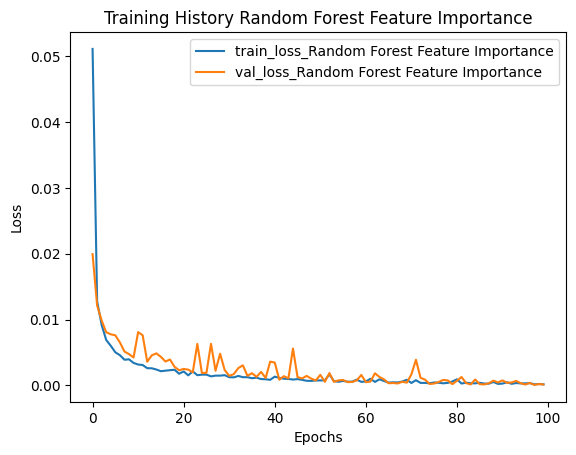

Epoch 1/100
130/130 [==============================] - 2s 5ms/step - loss: 5.9519 - accuracy: 0.8737 - val_loss: 4.5682 - val_accuracy: 0.9264
Epoch 2/100
130/130 [==============================] - 0s 3ms/step - loss: 3.9019 - accuracy: 0.8879 - val_loss: 2.4217 - val_accuracy: 0.9264
Epoch 3/100
130/130 [==============================] - 0s 4ms/step - loss: 2.5695 - accuracy: 0.9064 - val_loss: 3.0533 - val_accuracy: 0.9264
Epoch 4/100
130/130 [==============================] - 1s 4ms/step - loss: 2.0208 - accuracy: 0.9209 - val_loss: 0.7072 - val_accuracy: 0.9423
Epoch 5/100
130/130 [==============================] - 1s 4ms/step - loss: 1.3431 - accuracy: 0.9249 - val_loss: 0.1102 - val_accuracy: 0.9776
Epoch 6/100
130/130 [==============================] - 0s 4ms/step - loss: 1.0892 - accuracy: 0.9399 - val_loss: 0.0520 - val_accuracy: 0.9870
Epoch 7/100
130/130 [==============================] - 0s 3ms/step - loss: 0.8476 - accuracy: 0.9411 - val_loss: 0.5125 - val_accuracy: 0.9481

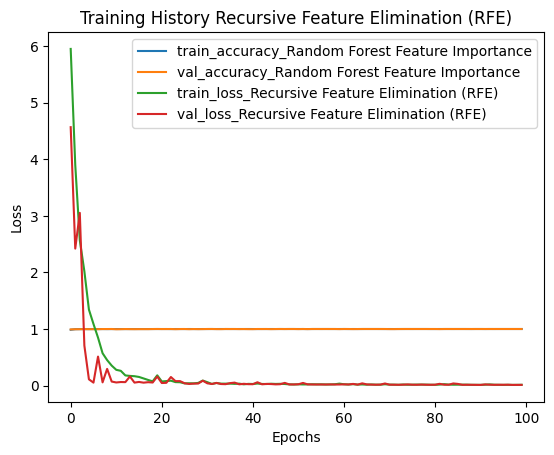

3/3 [==============================] - 0s 9ms/step
LSTM - Random Forest Prediction ['snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow'
 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain'
 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'snow' 'rain' 'rain'
 'rain' 'snow' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow'
 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain'
 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain'
 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow'
 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain'
 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain'
 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow'
 'rain' 'rain' 'rain' 'snow' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain'
 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain'
 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' 'snow' 'rain' 'rain' '

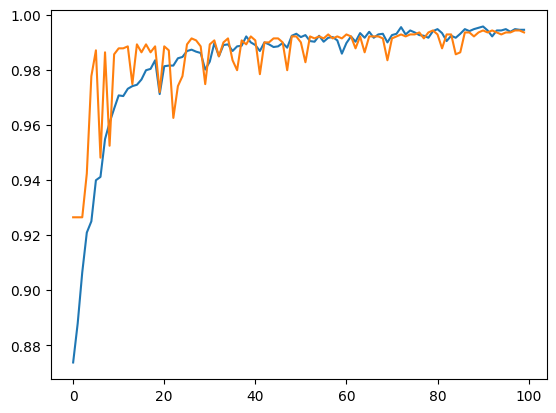

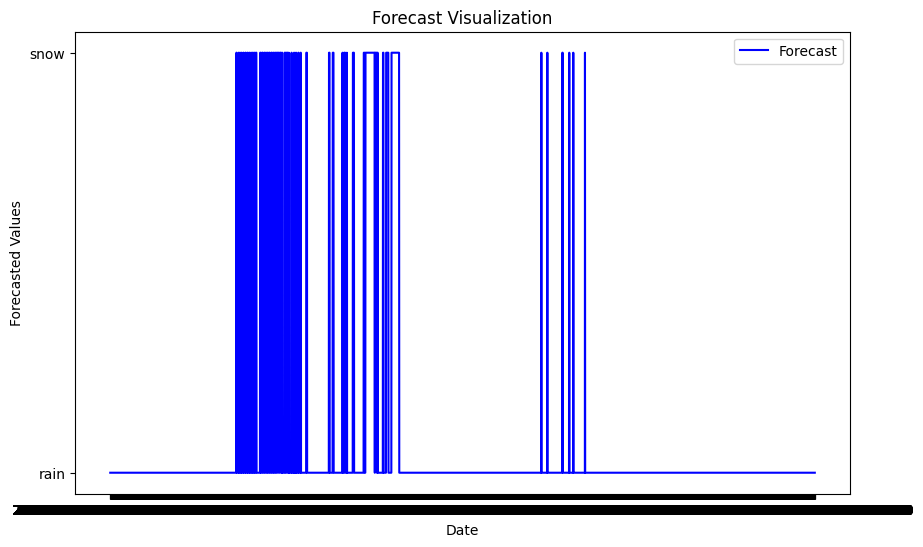

In [11]:
if __name__ == "__main__":
	weather_data, label_encoder = read_file()

	# Visualise the correlation
	visualize_correlation(weather_data)
	y, selected_features_rf, selected_features_rfe = get_feature_importance(weather_data)

	# Split the data into training and testing sets
	X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(selected_features_rf, y, test_size=0.2, random_state=42)
	X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(selected_features_rfe, y, test_size=0.2, random_state=42)

	# Split the training data further into training and validation sets (60% training, 20% validation)
	x_train_rf, x_val_rf, y_train_rf, y_val_rf = train_test_split(X_train_rf, y_train_rf, test_size=0.25, random_state=42)
	x_train_rfe, x_val_rfe, y_train_rfe, y_val_rfe = train_test_split(X_train_rfe, y_train_rfe, test_size=0.25, random_state=42)

	# Get the best hyperparameters for each model
	num_classes = 1
	best_model_rf, best_hp_rf = find_hyperparameters(x_train_rf, y_train_rf, x_val_rf, y_val_rf, num_classes, "Random Forest Feature Importance")
	best_model_rfe, best_hp_rfe = find_hyperparameters(x_train_rfe, y_train_rfe, x_val_rfe, y_val_rfe, num_classes, "Recursive Feature Elimination (RFE)")

	# Run each model and get their result
	rf_model = run_model(x_train_rf, y_train_rf, x_val_rf, y_val_rf, best_model_rf, "Random Forest Feature Importance")
	rfe_model = run_model(x_train_rfe, y_train_rfe, x_val_rfe, y_val_rfe, best_model_rfe, "Recursive Feature Elimination (RFE)")

	# Generate for 3 days, each day has 24 hours so 3*24.
	generated_data_rf = generate_data(x_train_rf, 3*24)
	generated_data_rfe = generate_data(x_train_rfe, 3*24)

	# Predict the weather for the generated data.
	rf_prediction = rf_model.predict(generated_data_rf)
	rfe_prediction = rfe_model.predict(generated_data_rfe)

	rf_df = pd.DataFrame(rf_prediction)
	new_df_rf = pd.DataFrame()

	# Loop through each row of the original DataFrame
	for index, row in rf_df.iterrows():
		# Get the maximum value in the row
		max_value = row.max()
		# Append the maximum value to the new DataFrame
		new_df_rf = pd.concat([rf_df, pd.DataFrame({'Highest_Value': [max_value]})], ignore_index=True)

	rfe_df = pd.DataFrame(rfe_prediction)
	new_df_rfe = pd.DataFrame()

	# Loop through each row of the original DataFrame
	for index, row in rfe_df.iterrows():
		# Get the maximum value in the row
		max_value = row.max()
		# Append the maximum value to the new DataFrame
		new_df_rfe = pd.concat([rfe_df, pd.DataFrame({'Highest_Value': [max_value]})], ignore_index=True)

	np_rf = new_df_rf.to_numpy()
	np_rfe = new_df_rfe.to_numpy()

	# Now 'flattened_prediction' contains the flattened array with values set to either 0 or 1
	rf_labels = np.where(np_rf.flatten() >= 0.5, 1, 0)
	rfe_labels = np.where(np_rfe.flatten() >= 0.5, 1, 0)

	# Get the original label ("Rain", "Snow") based on their value
	original_labels_rf = label_encoder.inverse_transform(rf_labels)
	original_labels_rfe = label_encoder.inverse_transform(rfe_labels)

	# Print the prediction
	print("LSTM - Random Forest Prediction", original_labels_rf)
	print("LSTM - Recursive Feature Elimination Prediction", original_labels_rfe)

	# Read the updated dataset to visualize the weather
	weather_data = pd.read_csv('./updated_dataset.csv')
	combined_data_rfe = pd.concat([pd.DataFrame(rfe_labels), generated_data_rfe], axis=1)
	weather_data = pd.concat([weather_data, combined_data_rfe], axis=1)


	# Plot the forecast
	plt.figure(figsize=(10, 6))
	plt.plot(weather_data["Formatted Date"], weather_data["Temperature (C)"], label='Forecast', color='blue')

	# Add labels and title
	plt.xlabel('Date')
	plt.ylabel('Forecasted Values')
	plt.title('Forecast Visualization')

	# Add legend
	plt.legend()

	# Show plot
	plt.show()

To summarize, given the current dataset I can say with confidence that using the features that were given by the Recursive Feature Elimination where the optimal solution. So, I'll add the generated RFE data to the saved file for further analysis.

The following import and code, is a basic database creation and a simple API to get and post data for further analysis.

In [12]:
!pip install flask_sqlalchemy

The following code is a simple API call and database creation for keeping and retrieving records. The database table has all the features deemed important from the Recursive Feature Elimination. The GET method retrieves all the data from the database as a JSON file. Finally, the POST method is for adding new data to the table.

In [13]:
from flask import Flask, jsonify, request
from flask_sqlalchemy import SQLAlchemy
from datetime import datetime, timezone

app = Flask(__name__)
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///forecast.db'
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
db = SQLAlchemy(app)

# Create a class for the table in the database
class Forecast(db.Model):
    formatted_date = db.Column(db.String, primary_key=True)
    temperature = db.Column(db.Float, nullable=False)
    apparent_temperature = db.Column(db.Float, nullable=False)
    humidity = db.Column(db.Float, nullable=False)
    visibility = db.Column(db.Float, nullable=False)
    pressure = db.Column(db.Float, nullable=False)
    prediction = db.Column(db.String, nullable=False)

    def __repr__(self):
        return f'<Date {self.formatted_date}: Temp={self.temperature}, Apparent Temperature={self.apparent_temperature}, Humidity={self.humidity}, Visibility={self.visibility}, Pressure={self.pressure}, Prediction={self.prediction}>'


# This function retrieves all forecast records from the database and returns them as JSON data
@app.route('/forecast', methods=['GET'])
def get_forecast():
    with app.app_context():
        forecasts = Forecast.query.all()
        forecast_data = [{'formatted_date': forecast.formatted_date, 'temperature': forecast.temperature, 'apparent_temperature': forecast.apparent_temperature,'humidity': forecast.humidity, 'visibility': forecast.visibility, 'pressure': forecast.pressure, 'prediction': forecast.pred} for forecast in forecasts]
    return jsonify(forecast_data)


# For adding a new forecast record to the database based on the JSON data
@app.route('/forecast', methods=['POST'])
def post_forecast():
    data = request.get_json()
    formatted_date = datetime.strptime(data['formatted_date'], '%Y-%m-%d %H:%M:%S')
    with app.app_context():
        new_forecast = Forecast(formatted_date=formatted_date,
                                apparent_temperature=data['apparent_temperature'],
                                humidity=data['humidity'],
                                visibility=data['visibility'],
                                pressure=data['pressure'],
                                prediction=data['prediction'])
        db.session.add(new_forecast)
        db.session.commit()
    return jsonify({'message': 'Forecast added successfully'}), 201

if __name__ == '__main__':
    with app.app_context():
        db.create_all()
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
